
# COS30049 - Assignment 2
### Session 26 Group 2
### Swinburne Univeristy of Technology

## Objective
- insert project objective


- using clean-text, spacy
- python -m spacy download en_core_web_sm

### 1.1 Test if the ML reads the file

We have a dataset named `Constraint_English_Train.xlsx`. We use pd.read_excel() to read the file, and .head() to retrieve the first 5 data from the set.

In [53]:
import pandas as pd

# Load dataset
file_path = "Constraint_English_Train.xlsx"
misinfo_data = pd.read_excel(file_path)

# Preview first few rows
print(misinfo_data.head())

   id                                              tweet label
0   1  The CDC currently reports 99031 deaths. In gen...  real
1   2  States reported 1121 deaths a small rise from ...  real
2   3  Politically Correct Woman (Almost) Uses Pandem...  fake
3   4  #IndiaFightsCorona: We have 1524 #COVID testin...  real
4   5  Populous states can generate large case counts...  real


### 1.2 Test that the ML can retrieve data from set that contains input
- using `import` re
- We use .compile() for a pattern we want to find from the data set containing "CDC".



In [54]:
import pandas as pd
import re

file_path = "Constraint_English_Train.xlsx"
misinfo_data = pd.read_excel(file_path)

# Compile the regex pattern
pattern = re.compile(r'CDC', re.IGNORECASE)  # ignore case if needed

# Example: check in a specific column, e.g., 'text'
if 'text' in misinfo_data.columns:
    matches = misinfo_data['text'].apply(lambda x: bool(pattern.search(str(x))))
    print("Rows containing 'CDC':")
    print(misinfo_data[matches])
else:
    # If you want to search all columns
    matches = misinfo_data.applymap(lambda x: bool(pattern.search(str(x))))
    print("Rows containing 'CDC':")
    print(misinfo_data[matches.any(axis=1)])

Rows containing 'CDC':
        id                                              tweet label
0        1  The CDC currently reports 99031 deaths. In gen...  real
6        7  If you tested positive for #COVID19 and have n...  real
27      28  Just Appendix B gathering all the state orders...  real
33      34  CDC Recommends Mothers Stop Breastfeeding To B...  fake
138    139  Youth sports organizations: As you resume acti...  real
...    ...                                                ...   ...
6338  6339  ???The CDC can detain anyone with a fever ??" ...  fake
6345  6346  1645 deaths were reported today bringing the t...  real
6377  6378  Acc to @CDCgov &amp; @WHO there is currently n...  real
6391  6392  The CDC ???adjusted the US Covid deaths from 1...  fake
6405  6406  The cloth face coverings recommended to slow s...  real

[281 rows x 3 columns]


/var/folders/w0/r8xr9pyn4w19x3x9z5x82hm00000gn/T/ipykernel_13974/3022997758.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  matches = misinfo_data.applymap(lambda x: bool(pattern.search(str(x))))


# Test emoji detection

In [5]:
import pandas as pd
import re

df = pd.DataFrame({
    'text': ["Hello world", "Hi there 😀", "@user_name is cool", "No emojis here!"]
})

pattern = re.compile(r'[^\w\s@]', flags=re.UNICODE)
df['has_emoji'] = df['text'].apply(lambda x: bool(pattern.search(str(x))))

print(df)

                 text  has_emoji
0         Hello world      False
1          Hi there 😀       True
2  @user_name is cool      False
3     No emojis here!       True


# Test emoji refining

In [33]:
import pandas as pd
import re

file_path = "Constraint_English_Train_GR.xlsx"
misinfo_data = pd.read_excel(file_path)
df = pd.DataFrame(misinfo_data)

# Step 1: Clean text safely
def clean_text(text):
    text = str(text)
    
    # Step 1a: Protect @usernames and #hashtags
    placeholders = {}
    for match in re.findall(r'(@\w+|#\w+)', text):
        ph = f"PLACEHOLDER{len(placeholders)}"
        placeholders[ph] = match
        text = text.replace(match, ph)
    
    # Step 1b: Replace all underscores with spaces
    text = text.replace('_', ' ')
    
    # Step 1c: Remove emojis / unusual symbols
    # Keep letters, numbers, whitespace, @, #, ., ,, !, ?
    text = re.sub(r'[^\w\s@.,!?#]', '', text, flags=re.UNICODE)
    
    # Step 1d: Remove leading punctuation (like . , ! ?) at start of text
    text = re.sub(r'^[.,!?_\s]+', '', text)
    
    # Step 1e: Restore usernames and hashtags
    for ph, original in placeholders.items():
        text = text.replace(ph, original)
    
    return text

# Apply cleaning function to the 'tweet' column
df['clean_text'] = df['tweet'].apply(clean_text)

# Optional: preview result
print(df[['tweet', 'clean_text']])

# Save cleaned file
df.to_excel("Constraint_English_Train_Cleaned.xlsx", index=False)

/opt/anaconda3/envs/ctip/lib/python3.13/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


                                                  tweet  \
0     The CDC currently reports 99031 deaths. In gen...   
1     States reported 1121 deaths a small rise from ...   
2     Politically Correct Woman (Almost) Uses Pandem...   
3     #IndiaFightsCorona: We have 1524 #COVID testin...   
4     Populous states can generate large case counts...   
...                                                 ...   
6415  A tiger tested positive for COVID-19 please st...   
6416  Autopsies prove that COVID-19 is a blood clot,...   
6417  _A post claims a COVID-19 vaccine has already ...   
6418  Aamir Khan Donate 250 Cr. In PM Relief Cares Fund   
6419  It has been 93 days since the last case of COV...   

                                             clean_text  
0     The CDC currently reports 99031 deaths. In gen...  
1     States reported 1121 deaths a small rise from ...  
2     Politically Correct Woman Almost Uses Pandemic...  
3     #IndiaFightsCorona We have 1524 #COVID testing...  
4

# How to improve data cleaning and preprocessing?
- use spelling correction libraries: TextBlob, pyspellchecker, SymSpell, BERT-based models

# Test Frequency of Words
### Needs filtering

In [3]:
import pandas as pd
import re
from collections import Counter

# Load the dataset
file_path = "Constraint_English_Train_Cleaned.xlsx"
misinfo_data = pd.read_excel(file_path)

# Combine all text into a single string
text_data = ""

# If there's a 'text' column, use that; otherwise, use all text-like columns
if 'text' in misinfo_data.columns:
    text_data = " ".join(misinfo_data['text'].astype(str))
else:
    # concatenate all string columns
    text_data = " ".join(misinfo_data.astype(str).agg(' '.join, axis=1))
    

# Preprocess text: lowercase, remove punctuation (optional)
text_data = text_data.lower()
# Replace country mentions of "us" with "US"
# This regex tries to match 'us' as a standalone word, not part of another word
text_data = re.sub(r'\bus\b', 'US', text_data, flags=re.IGNORECASE)
text_data = re.sub(r'[^\w\s]', '', text_data)  # remove punctuation

# Split into words
words = text_data.split()

# Define stopwords and words to remove
stopwords = set([
    'the', 'and', 'is', 'in', 'it', 'of', 'to', 'a', 'for', 'on', 
    'with', 'as', 'by', 'at', 'an', 'be', 'this', 'that', 'from', 'or',
    'there', 'about',
    # Helpful verbs / prepositions
    'are', 'were', 'was', 'have', 'has', 'had', 'do', 'does', 'did', 'can', 'could', 'should',
    'i', 'you', 'he', 'she', 'they', 'we', 'them', 'him', 'her', 'its', 'my', 'your', 'our',
    'will', 'been',
    # Specific words to ignore
    'real', 'fake',
    # Pronoun / Noun / Adjective
    'there', 'not', 'who', 'number', 'total', 'all', 'no', 'new', 'today', 'up', 'one', 
    # Conjunction
    'than', 'more', 'now', 'but', 'if', 'which'
])

# Filter out stopwords
words = [w for w in words if w not in stopwords]

# Count word frequencies
word_counts = Counter(words)

# Show the top 100 most common words
print("Top 100 words in dataset:")
for word, count in word_counts.most_common(100):
    print(f"{word}: {count}")

Top 100 words in dataset:
covid19: 6307
cases: 3444
coronavirus: 3250
people: 1489
tests: 1393
deaths: 1290
states: 1156
confirmed: 1030
reported: 956
testing: 934
covid: 886
health: 842
india: 820
state: 694
report: 668
indiafightscorona: 640
virus: 619
pandemic: 616
case: 594
patients: 587
vaccine: 570
update: 570
says: 568
1: 559
their: 552
data: 546
hospital: 540
rt: 532
tested: 530
positive: 524
over: 520
days: 517
test: 502
2: 497
only: 492
day: 484
daily: 468
may: 468
after: 464
trump: 462
2020: 459
last: 452
active: 452
lockdown: 445
see: 444
spread: 442
US: 442
rate: 430
out: 428
video: 423
recovered: 414
when: 410
so: 402
during: 402
also: 398
world: 390
shows: 382
million: 378
yesterday: 368
3: 359
these: 356
other: 354
two: 354
news: 349
president: 344
some: 344
get: 342
isolation: 340
death: 336
being: 334
since: 332
numbers: 332
first: 330
government: 323
mohfw_india: 322
risk: 322
said: 320
country: 314
due: 314
discharged: 314
coronavirusupdates: 312
home: 311
cdc: 308


# Test: Word Frequency Chart
### Needs to be revised

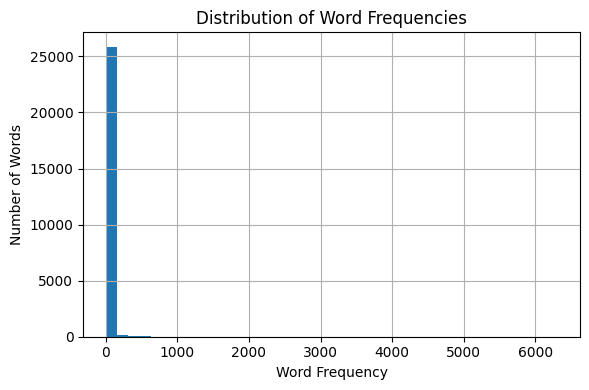

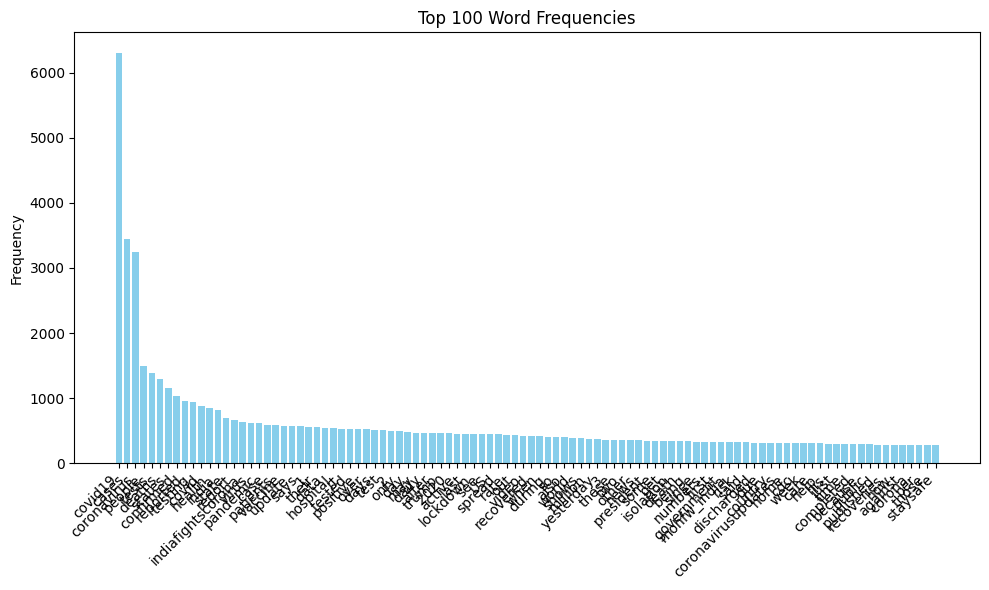

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Suppose this is your earlier result
# word_counts = Counter(words)  # from your previous code

# Convert Counter to DataFrame
df = pd.DataFrame(word_counts.items(), columns=['Word', 'Word Frequency'])

# Optional: sort by frequency
df = df.sort_values(by='Word Frequency', ascending=False).reset_index(drop=True)

# Now you can plot a histogram
plt.figure(figsize=(6,4))
df['Word Frequency'].hist(bins=40)
plt.title('Distribution of Word Frequencies')
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.tight_layout()
plt.show()

# Or plot top 20 words as a bar chart
top_n = 100
df_top = df.head(top_n)
plt.figure(figsize=(10,6))
plt.bar(df_top['Word'], df_top['Word Frequency'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title(f'Top {top_n} Word Frequencies')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# How we can improve word frequency:


## 1. Automate stopward removal
- Use built-in lists (from NLTK or Scikit-learn) so we don't miss out words.

In [35]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stopwords = set(ENGLISH_STOP_WORDS)

## 2. Use frequency thresholds
- FIlter words that appear too many times (eg. typos or irrelevant words). Rare words may also be noise.

In [5]:
from collections import Counter

text = "The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today."
words = text.split() 

min_freq = 2
word_counts = Counter(words)
words = [w for w in words if word_counts[w] >= min_freq]

print(words)

['The', 'death', 'The', 'death']



## 3. Keep bigrams or phrases
- To avoid context loss caused by single words, we can add bigrams (pair of words) to capture patterns. Eg. "fake news", "breaking news".

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words="english")
X_counts = vectorizer.fit_transform(misinfo_data['clean_text'])

## 4. Integrate filtering with TF-IDF
- Apparent TF-IDF already has a method for handling word frequency filtering.

In [7]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, min_df=5, max_df=0.9, stop_words="english")

	What the code does is it removes:
    - Words appearing too rarely (min_df)
	- Words appearing in almost all documents (max_df)
	- Stopwords automatically (stop_words="english")

# Improved word frequency filtering

In [8]:
import pandas as pd
import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\bus\b', 'US', text, flags=re.IGNORECASE)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

def get_word_frequencies(df, text_column, stopwords=None, min_freq=1):
    all_text = " ".join(df[text_column].astype(str).apply(clean_text))
    words = all_text.split()
    if stopwords:
        words = [w for w in words if w not in stopwords]
    counts = Counter(words)
    return {word: count for word, count in counts.items() if count >= min_freq}

# Load data
df = pd.read_excel("Constraint_English_Train_Cleaned.xlsx")

# Use sklearn stopwords
stopwords = set(ENGLISH_STOP_WORDS)

# Get frequencies
word_freq = get_word_frequencies(df, "clean_text", stopwords=stopwords, min_freq=5)

# Display top 100 words
for word, count in Counter(word_freq).most_common(100):
    print(f"{word}: {count}")

covid19: 3154
cases: 1722
coronavirus: 1619
new: 1092
people: 745
tests: 697
deaths: 645
states: 578
total: 540
number: 535
confirmed: 515
reported: 478
testing: 467
covid: 459
health: 421
india: 412
today: 371
state: 347
report: 334
indiafightscorona: 320
pandemic: 311
virus: 310
case: 297
patients: 294
vaccine: 286
update: 285
says: 284
1: 279
data: 273
hospital: 270
rt: 266
tested: 265
positive: 262
days: 259
test: 251
2: 248
day: 242
daily: 234
trump: 231
2020: 229
active: 226
lockdown: 223
spread: 221
US: 221
rate: 215
video: 212
recovered: 207
world: 195
shows: 191
million: 189
yesterday: 184
3: 179
news: 174
president: 172
isolation: 170
death: 168
numbers: 166
government: 162
mohfw_india: 161
risk: 161
said: 160
country: 157
discharged: 157
home: 156
cdc: 154
week: 153
help: 152
care: 152
time: 149
just: 149
completed: 148
public: 145
published: 142
recoveries: 142
coronavirusupdates: 141
corona: 139
staysafe: 137
claims: 135
reporting: 135
community: 133
nigeria: 132
lakh: 131

# Keep scrolling to Week 8 after this...

### 1.3 Test
- Maybe we can do a test using longer sentences here


- **Using Regular Expressions**: Regular expressions give us the ability to search for patterns within text, strings, files, etc. They serve several uses, such as; security measures, searching, filtering, pattern recognition, and more... \\
  a) `re.compile()` : using compile, pre determines the string to be used in regular expression methods. \\
  b) `re.match()` :  This method attempts to match a pattern at the beginning of the string. \\
  c) `re.findall` : This method returns a list of all non-overlapping matches of a pattern in the string, as a list of strings. \\
  d) `re.search()` : This method scans through the string, looking for any location where the pattern matches.  \\

In [42]:
# add pattern abcd
pattern = re.compile('CDC')
print(pattern)

re.compile('CDC')


- **Sets**: The following cells will allow you to use regular expressions to search for certain values within a range. \\
  a) Integer Ranges: For example, [0-7] \\
  b) Character Ranges: For exampe, [A-Z][a-z] \\

TL;DR (Regex Text Preprocessing) "Match Mathod"

[Checks if a pattern is at the start of the string]

In [ ]:
import re

pattern = re.compile(r'The')

match = pattern.match(misinfo_data['tweet'][0]) # [0] = first tweet
print(match) 


<re.Match object; span=(0, 3), match='The'>


TL;DR (Regex text preprocessing) "Search Method"

[Finds a pattern anywhere in the string]

In [10]:
import re

pattern = re.compile(r'deaths')

match = pattern.search(misinfo_data['tweet'][0]) # [0] = first tweet
print(match) 


<re.Match object; span=(32, 38), match='deaths'>


In [12]:
# use this pattern to find '123abcd abcd123 abcd abcabc acb'
finders = pattern.findall('CDC')
print(finders)

[]


In [ ]:
# explain the code blow
random_string = 'CDC'

search = pattern.search(random_string)
print(search)
span = search.span()
print(span)
print(random_string[span[0] : span[1]])

None


AttributeError: 'NoneType' object has no attribute 'span'

In [14]:
random_string = 'CDC'
search = pattern.search(random_string)

if search:  # only if a match was found
    span = search.span()
    print(span)
    print(random_string[span[0] : span[1]])
else:
    print("No match found.")

No match found.


In [15]:
# Compile a regular expression pattern [0-7][7-9][0-3] and search for this pattern in the string '67383'.
# If a match is found, print the match object and the character at the start position of the match.
pattern_int = re.compile('[0-7][7-9][0-3]')

random_numbers = pattern_int.search('67383')
print(random_numbers)
span = random_numbers.span()
print(random_numbers[span[0]])

<re.Match object; span=(0, 3), match='673'>
673


In [16]:
# Compile a regular expression pattern [A-Z][a-z] to match any sequence of an uppercase letter followed by a lowercase letter.
# Use the findall method to find all such sequences in the string 'Hello there Mr. Ricky' and print the list of matches
char_pattern = re.compile('[A-Z][a-z]')
found = char_pattern.findall('Hello there Mr. Ricky')
print(found)

['He', 'Mr', 'Ri']


- **Counting Occurences**: The following cells will allow you to use regular expressions to search for certain values within a range. \\

  a) `{x}` :  something that occurs {num_of_times}. \\
  b) `{, x}` : {x, x} - something that occurs between x and x times  \\
  c) `{?}` : something that occurs 0 or 1 time \\
  d) `{*}` : * - something that occurs at least 0 times \\
  e) `{+}`: + - something that occurs at least once \\



In [64]:
# Compile a regular expression pattern `[A-Z][a-z][0-3]{2}` to match any sequence of an uppercase letter, a lowercase letter,
# and two digits ranging from 0 to 3. Use the `findall` method to find all such sequences in the string `'Hello Mr. Ri03cky'` and print the list of matches.
char_pattern_count = re.compile('[A-Z][a-z][0-3]{2}')
found_count = char_pattern_count.findall('Hello Mr. Ri03cky')
print(found_count)

['Ri03']


In [65]:
# Compile a regular expression pattern m{1,5} to match any sequence of 1 to 5 consecutive 'm' characters.
# Use the findall method to find all such sequences in the string 'This is an example of a regular expression trying to find one m,
# more than one mmm or five mmmmms' and print the list of matches.
random_pattern = re.compile('m{1,5}')
random_statement = random_pattern.findall('This is an example of a regular expression trying to find one m, more than one mmm or five mmmmms')
print(random_statement)

['m', 'm', 'm', 'mmm', 'mmmmm']


In [66]:
# Compile a regular expression pattern Mrss? to match the string 'Mrs' optionally followed by an 's'.
# Use the findall method to find all such sequences in the string 'Hello M there Mr. Anderson, Mid how is Mrs. Anderson, and Mrss. Anderson?'
# and print the list of matches.
pattern = re.compile('Mrss?')
found_pat = pattern.findall('Hello M there Mr. Ricky, Mid how is Mrs. Ricky, and Mrss. Ricky?')
print(found_pat)

['Mrs', 'Mrss']


- **Escaping Character**:

  a) `\w` :  look for any Unicode character \\
  b) `\W` :  look for anything that isnt a Unicode character \\

  More escaping characters please inspect : https://learn.microsoft.com/en-us/dotnet/standard/base-types/character-escapes-in-regular-expressions

In [ ]:
# Compile two regular expression patterns: [\w]+ to find sequences of word characters and
# [\W]+ to find sequences of non-word characters. Use the findall method to search for these patterns in the string and print the results.
pattern_1 = re.compile('[\w]+')
pattern_2 = re.compile('[\W]+')

found_1 = pattern_1.findall('This is a sentence. With, exclamation mark at the end!')
found_2 = pattern_2.findall('This is a sentence. With, exclamation mark at the end!')

print(found_1)
print(found_2)

# Week 8 - Sentiment Analysis

Validation Results:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1020
           1       0.95      0.87      0.91      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140

Test Results:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1020
           1       0.95      0.86      0.90      1120

    accuracy                           0.90      2140
   macro avg       0.90      0.90      0.90      2140
weighted avg       0.91      0.90      0.90      2140

KNN Validation Results:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1020
           1       0.95      0.79      0.86      1120

    accuracy                           0.87      2140
   macro avg       0.88      0.87      0.87      2140
weighted avg    

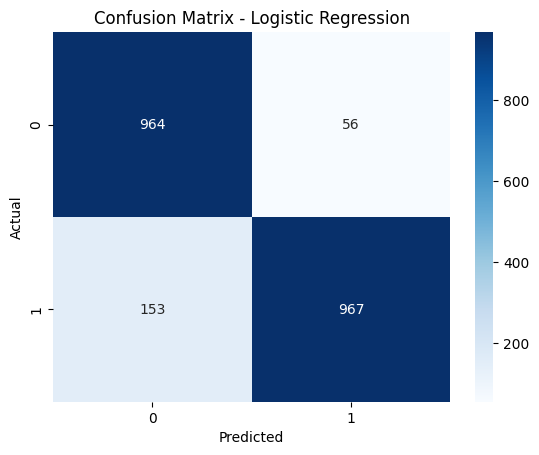

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. Load datasets ===
train_df = pd.read_excel("Constraint_English_Train_Cleaned.xlsx")
val_df = pd.read_excel("Constraint_English_Val .xlsx")
test_df = pd.read_excel("Constraint_English_Test.xlsx")

X_train = train_df['clean_text']
y_train = train_df['label'].map({'real': 1, 'fake': 0})

X_val = val_df['tweet'] # NEED TO CLEAN
y_val = val_df['label'].map({'real': 1, 'fake': 0})

X_test = test_df['tweet'] # NEED TO CLEAN
y_test = test_df['label'].map({'real': 1, 'fake': 0})

# === 2. TF-IDF vectorization ===
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)  # Learn vocabulary from train set
X_val_vec = vectorizer.transform(X_val)          # Use the same vocabulary
X_test_vec = vectorizer.transform(X_test)

# === 3. Train Logistic Regression ===
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_vec, y_train)

# === 4. Validate model ===
y_val_pred = log_reg.predict(X_val_vec)
print("Validation Results:")
print(classification_report(y_val, y_val_pred))

# === 5. Test model ===
y_test_pred = log_reg.predict(X_test_vec)
print("Test Results:")
print(classification_report(y_test, y_test_pred))

# === 6. Optional: KNN ===
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_vec, y_train)

y_val_pred_knn = knn.predict(X_val_vec)
print("KNN Validation Results:")
print(classification_report(y_val, y_val_pred_knn))

y_test_pred_knn = knn.predict(X_test_vec)
print("KNN Test Results:")
print(classification_report(y_test, y_test_pred_knn))

# === 7. Metrics and Confusion Matrix ===
# print(f"Training size: {len(X_train)}")
# print(f"Validation size: {len(X_val)}")
# print(f"Test size: {len(X_test)}")
# print(f"Classes in training set:\n{y_train.value_counts()}")
# print(f"Classes in validation set:\n{y_val.value_counts()}")
# print(f"Classes in test set:\n{y_test.value_counts()}")

print("Logistic Regression Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Logistic Regression Test F1 Score:", f1_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Word frequency filtering + Sentiment Analysis

## Need to clean and preprocess test and val datasets
## 

Validation Results:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1020
           1       0.91      0.91      0.91      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140

Test Results:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1020
           1       0.92      0.92      0.92      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140

KNN Validation Results:
              precision    recall  f1-score   support

           0       0.56      1.00      0.72      1020
           1       0.99      0.30      0.46      1120

    accuracy                           0.63      2140
   macro avg       0.78      0.65      0.59      2140
weighted avg    

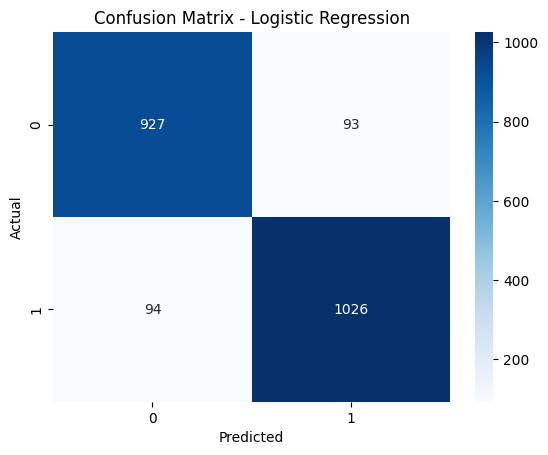

Example bigrams learned by the vectorizer:
['04 2020', '0800 confirmed', '0930 pm', '10 days', '10 lakh', '10 million', '10 seconds', '10 statesuts', '100 people', '1000 deaths', '10000 cases', '100000 people', '1000190000 confirmed', '11 people', '110000 confirmed', '115000 confirmed', '1154 number', '13 states', '14 days', '1481 case', '15 days', '15 minutes', '15 states', '1504 number', '16 indiafightscorona', '16 significant', '17 indiafightscorona', '18 indiafightscorona', '19 fct', '20 million', '20 oyo', '2020 0800', '2020 indiafightscorona', '2020 september', '2020 states', '2020 staysafe', '2020 steady', '20s arrived', '22 active', '23 lakh', '24 hours', '24 hrs', '25 2020', '28 days', '2pm et', '39 imported', '43 lakh', '48 hours', '50 states', '60 total']
Top TF-IDF bigrams in example post:
100000 people: 0.2991
death toll: 0.2400
04 2020: 0.0000


In [27]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re

# === 1. Text cleaning function ===
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\bus\b', 'US', text, flags=re.IGNORECASE)  # Keep 'US'
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.strip()

# === 2. Load datasets ===
train_df = pd.read_excel("Constraint_English_Train_Cleaned.xlsx")
val_df = pd.read_excel("Constraint_English_Val .xlsx")
test_df = pd.read_excel("Constraint_English_Test.xlsx")

# Clean text
train_df['clean_text'] = train_df['tweet'].apply(clean_text)
val_df['clean_text'] = val_df['tweet'].apply(clean_text)
test_df['clean_text'] = test_df['tweet'].apply(clean_text)

# Labels
y_train = train_df['label'].map({'real': 1, 'fake': 0})
y_val = val_df['label'].map({'real': 1, 'fake': 0})
y_test = test_df['label'].map({'real': 1, 'fake': 0})

# === 3. TF-IDF vectorization with improvements ===
stopwords = list(ENGLISH_STOP_WORDS)
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),      # Include unigrams and bigrams
    max_features=5000,       # Limit vocabulary size
    min_df=5,                # Minimum document frequency
    max_df=0.9,              # Remove very common words
    stop_words=stopwords  # Automated stopword removal
)

# Fit vectorizer on training data
X_train_vec = vectorizer.fit_transform(train_df['clean_text'])
X_val_vec = vectorizer.transform(val_df['clean_text'])
X_test_vec = vectorizer.transform(test_df['clean_text'])

# === 4. Train Logistic Regression ===
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_vec, y_train)

# === 5. Validate model ===
y_val_pred = log_reg.predict(X_val_vec)
print("Validation Results:")
print(classification_report(y_val, y_val_pred))

# === 6. Test model ===
y_test_pred = log_reg.predict(X_test_vec)
print("Test Results:")
print(classification_report(y_test, y_test_pred))

# === 7. Optional: KNN ===
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_vec, y_train)

y_val_pred_knn = knn.predict(X_val_vec)
print("KNN Validation Results:")
print(classification_report(y_val, y_val_pred_knn))

y_test_pred_knn = knn.predict(X_test_vec)
print("KNN Test Results:")
print(classification_report(y_test, y_test_pred_knn))

# === 8. Metrics and Confusion Matrix ===
print("Logistic Regression Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Logistic Regression Test F1 Score:", f1_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


# === Bigrams produces
# Assuming vectorizer is already fitted
feature_names = vectorizer.get_feature_names_out()

# Filter for bigrams only (two words)
bigrams = [f for f in feature_names if len(f.split()) == 2]

print("Example bigrams learned by the vectorizer:")
print(bigrams[:50])  # show first 50 bigrams

# == Bigrams TF-IDF values
import numpy as np

# Transform a single example
example_vec = vectorizer.transform([X_train.iloc[0]])  

# Get feature names and scores
scores = zip(feature_names, example_vec.toarray()[0])

# Sort by score descending
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

print("Top TF-IDF bigrams in example post:")
for term, score in sorted_scores[:20]:
    if len(term.split()) == 2:
        print(f"{term}: {score:.4f}")
